In [1]:
import VariationalBayes as vb
import VariationalBayes.ExponentialFamilies as ef

import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, unpack_csr_matrix, get_sparse_hessian

import matplotlib.pyplot as plt
%matplotlib inline

#import numpy as np

import autograd
import autograd.numpy as np

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)

pkl_file = open(pickle_output_filename, 'rb')
vb_results = pickle.load(pkl_file)


In [46]:
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
y_g_vec, y_vec, x_mat, glmm_par, prior_par = logit_glmm.load_json_data(json_filename)

K = x_mat.shape[1]
NG = np.max(y_g_vec) + 1

# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)


dict_keys(['mu_prior_mean', 'tau_prior_beta', 'K', 'N', 'x', 'beta_prior_mean', 'mu_prior_info', 'y', 'NG', 'tau_prior_alpha', 'beta_prior_info', 'y_group'])


In [45]:

# Load the glmer results
glmer_json_filename = os.path.join(data_dir, '%s_glmer_results.json' % analysis_name)
json_file = open(glmer_json_filename, 'r')
glmer_dat = json.load(json_file)
json_file.close()

print(glmer_dat.keys())

dict_keys(['beta_mean', 'beta_sd', 'glmm_time', 'mu_mean', 'tau_mean', 'u_cond_sd', 'beta_par', 'u_map', 'mu_sd'])


In [7]:

def get_mle_parameters(K, NG):
    mle_par = vb.ModelParamsDict('GLMER Parameters')
    mle_par.push_param(vb.VectorParam('mu'))
    mle_par.push_param(vb.VectorParam('tau'))
    mle_par.push_param(vb.VectorParam('beta', K))
    mle_par.push_param(vb.VectorParam('u', NG))

    return mle_par

def get_data_log_lik_terms(mle_par, x_mat, y_vec, y_g_vec):
    beta = mle_par['beta'].get()

    # atleast_1d is necessary for indexing by y_g_vec to work right.
    e_u = np.atleast_1d(mle_par['u'].get())

    # Log likelihood from data.
    z = e_u[y_g_vec] + np.squeeze(np.matmul(x_mat, beta))

    return y_vec * z - np.log1p(np.exp(z))

def get_re_log_lik(mle_par):
    mu = mle_par['mu'].get()
    tau = mle_par['tau'].get()
    u = mle_par['u'].get()

    return -0.5 * tau * np.sum(
        ((mu - u) ** 2)) +  0.5 * np.log(tau) * glmm_par['u'].size()

def get_log_prior(mle_par, prior_par):
    beta = mle_par['beta'].get()
    mu = mle_par['mu'].get()
    tau = mle_par['tau'].get()

    K = len(beta)
    log_p_beta = ef.mvn_prior(
        prior_mean = prior_par['beta_prior_mean'].get(),
        prior_info = prior_par['beta_prior_info'].get(),
        e_obs = beta,
        cov_obs = np.zeros((K, K)))

    log_p_mu = ef.uvn_prior(
        prior_mean = prior_par['mu_prior_mean'].get(),
        prior_info = prior_par['mu_prior_info'].get(),
        e_obs = mu,
        var_obs = 0.0)

    log_p_tau = ef.gamma_prior(
        prior_shape = prior_par['tau_prior_alpha'].get(),
        prior_rate = prior_par['tau_prior_beta'].get(),
        e_obs = tau,
        e_log_obs = np.log(tau))

    return log_p_beta + log_p_mu + log_p_tau


In [30]:

class LogisticGLMMMaximumLikelihood(object):
    def __init__(self, mle_par, prior_par, x_mat, y_vec, y_g_vec):

        self.mle_par = copy.deepcopy(mle_par)
        self.prior_par = copy.deepcopy(prior_par)
        self.x_mat = np.array(x_mat)
        self.y_vec = np.array(y_vec)
        self.y_g_vec = np.array(y_g_vec)

        assert np.min(y_g_vec) == 0
        assert np.max(y_g_vec) == self.mle_par['u'].size() - 1


    def get_log_lik(self):
        data_log_lik = np.sum(get_data_log_lik_terms(
            mle_par = self.mle_par,
            x_mat = self.x_mat,
            y_vec = self.y_vec,
            y_g_vec = self.y_g_vec))
        re_log_lik = get_re_log_lik(self.mle_par)
        log_prior = get_log_prior(self.mle_par, self.prior_par)
        return np.squeeze(data_log_lik + re_log_lik + log_prior)
    
    def get_log_loss(self):
        return -1 * self.get_log_lik()
    

In [52]:
mle_par = get_mle_parameters(K=K, NG=NG)
glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)
glmm_par.set_free(vb_results['glmm_par_free'])

set_from_glmer = True
if set_from_glmer:
    mle_par['beta'].set(np.array(glmer_dat['beta_mean']))
    mle_par['mu'].set(np.array(glmer_dat['mu_mean']))
    mle_par['tau'].set(np.array(glmer_dat['tau_mean']))
    mle_par['u'].set(np.array(glmer_dat['u_map']))
else:
    # Set from VB
    mle_par['beta'].set(glmm_par['beta'].e())
    mle_par['mu'].set(glmm_par['mu'].e())
    mle_par['tau'].set(glmm_par['tau'].e())
    mle_par['u'].set(glmm_par['u'].e())

model = LogisticGLMMMaximumLikelihood(mle_par, prior_par, x_mat, y_vec, y_g_vec)
print(model.get_log_lik())

objective = Objective(fun=model.get_log_loss, par=model.mle_par['u'])
print(objective.fun_free(model.mle_par['u'].get_free()))

-174.46702524191048
174.467025242


In [53]:

#u_free_init = model.mle_par['u'].get_free()
u_free_init = np.random.random(model.mle_par['u'].free_size())
objective.logger.initialize()
objective.logger.print_every = 1
mle_opt = optimize.minimize(
    lambda par: objective.fun_free(par, verbose=True),
    x0=u_free_init,
    method='trust-ncg',
    jac=objective.fun_free_grad,
    hessp=objective.fun_free_hvp,
    tol=1e-6, options={'maxiter': 200, 'disp': True, 'gtol': 1e-6 })
u_free_opt = mle_opt.x


Iter  0  value:  1418.11311409
	x_diff:  inf
Iter  1  value:  1355.83340249
	x_diff:  0.177328106601
Iter  2  value:  1236.05208963
	x_diff:  0.354477044041
Iter  3  value:  1015.64467796
	x_diff:  0.70724232857
Iter  4  value:  651.245659754
	x_diff:  1.40030049949
Iter  5  value:  220.164710037
	x_diff:  2.67844571696
Iter  6  value:  139.077697203
	x_diff:  1.56086077267
Iter  7  value:  137.790996119
	x_diff:  0.387151010828
Iter  8  value:  137.739016592
	x_diff:  0.109280391847
Iter  9  value:  137.735564943
	x_diff:  0.0311048636224
Iter  10  value:  137.735265342
	x_diff:  0.0121174715304
Iter  11  value:  137.735265223
	x_diff:  0.000152520140333
Iter  12  value:  137.735265223
	x_diff:  1.41684987298e-06
Optimization terminated successfully.
         Current function value: 137.735265
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
         Hessian evaluations: 0


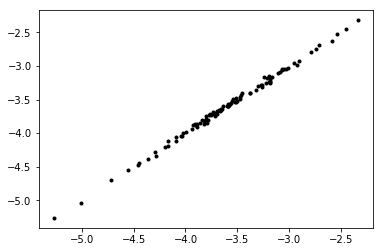

In [54]:
model.mle_par['u'].set_free(z_free_opt)
u_mle = model.mle_par['u'].get()

glmm_par.set_free(vb_results['glmm_par_free'])
u_vb = glmm_par['u'].e()

plt.plot(u_vb, u_mle, 'k.')